Based on: https://www.kaggle.com/code/ukveteran/cifar10-transfer-learning-vgg16-jma/notebook

In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np
import torch
import random
import time
from tqdm import tqdm # for progress bar
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelBinarizer

# Libraries for TensorFlow
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import datasets, layers, models, losses, Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import SGD
from keras import callbacks
# from livelossplot.inputs.keras import PlotLossesCallback
from keras.datasets import mnist, cifar10
from keras.utils import np_utils
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import LearningRateScheduler

# Library for Transfer Learning
from tensorflow.keras.applications import VGG16
from keras.applications.vgg16 import preprocess_input

In [2]:
# Pandas and Numpy for data structures and util fucntions
import scipy as sp
import numpy as np
import pandas as pd
from numpy.random import rand
pd.options.display.max_colwidth = 600

# Scikit Imports
from sklearn import preprocessing
from sklearn.metrics import roc_curve, auc, precision_recall_curve
from sklearn.model_selection import train_test_split


# Matplot Imports
import matplotlib.pyplot as plt
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (15, 5),
          'axes.labelsize': 'x-large',
          'axes.titlesize':'x-large',
          'xtick.labelsize':'x-large',
          'ytick.labelsize':'x-large'}

plt.rcParams.update(params)
%matplotlib inline

# pandas display data frames as tables
from IPython.display import display, HTML

import warnings
warnings.filterwarnings('ignore')

In [3]:
import tensorflow as tf
from keras import callbacks
from keras import optimizers
from keras.datasets import cifar10
from keras.applications import vgg16 as vgg
from keras.layers import Dropout, Flatten, Dense, GlobalAveragePooling2D,BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import np_utils

In [4]:
((trainX, trainY), (testX, testY)) = cifar10.load_data()
trainX = trainX.astype("float")
testX = testX.astype("float")
                                # Step 1
mean = np.mean(trainX, axis=0)
trainX -= mean
testX -= mean
                                # Step 2
lb = LabelBinarizer()
trainY = lb.fit_transform(trainY)
testY = lb.transform(testY)
                                # Step 3
aug = ImageDataGenerator(width_shift_range=0.1,height_shift_range=0.1, horizontal_flip=True,fill_mode="nearest")

In [5]:
BATCH_SIZE = 128
EPOCHS = 40
NUM_CLASSES = 10
LEARNING_RATE = 1e-4
MOMENTUM = 0.9

In [6]:
(X_train, y_train), (X_test, y_test) = cifar10.load_data()
X_train, X_val, y_train, y_val = train_test_split(X_train, 
                                                  y_train, 
                                                  test_size=0.15, 
                                                  stratify=np.array(y_train), 
                                                  random_state=42)
Y_train = np_utils.to_categorical(y_train, NUM_CLASSES)
Y_val = np_utils.to_categorical(y_val, NUM_CLASSES)
Y_test = np_utils.to_categorical(y_test, NUM_CLASSES)


In [7]:
base_model = vgg.VGG16(weights='imagenet', 
                       include_top=False, 
                       input_shape=(32, 32, 3))

# Extract the last layer from third block of vgg16 model
last = base_model.get_layer('block3_pool').output

for layer in base_model.layers:
     layer.trainable = False

2023-05-09 15:22:19.039610: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-09 15:22:21.346836: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 2153 MB memory:  -> device: 0, name: NVIDIA A40, pci bus id: 0000:e3:00.0, compute capability: 8.6


In [8]:
# # Add classification layers on top of it
# x = GlobalAveragePooling2D()(last)
# x= BatchNormalization()(x)
# x = Dense(256, activation='relu')(x)
# x = Dropout(0.6)(x)
# pred = Dense(NUM_CLASSES, activation='softmax')(x)
# model = Model(base_model.input, pred)

In [15]:
# Add classification layers on top of it
x = GlobalAveragePooling2D()(last)
x= BatchNormalization()(x)
x = Dense(256, activation='relu')(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.4)(x)
pred = Dense(NUM_CLASSES, activation='softmax')(x)
model = Model(base_model.input, pred)

In [16]:
model.compile(loss='binary_crossentropy',
              optimizer=Adam(lr=LEARNING_RATE),
              metrics=['accuracy'])

model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 32, 32, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 32, 32, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 16, 16, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 16, 16, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 16, 16, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 8, 8, 128)         0   

In [11]:
# prepare data augmentation configuration
train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    horizontal_flip=False)

train_datagen.fit(X_train)
train_generator = train_datagen.flow(X_train,
                                     Y_train, 
                                     batch_size=BATCH_SIZE)

val_datagen = ImageDataGenerator(rescale=1. / 255,
    horizontal_flip=False)

val_datagen.fit(X_val)
val_generator = val_datagen.flow(X_val,
                                 Y_val,
                                 batch_size=BATCH_SIZE)


In [17]:
train_steps_per_epoch = X_train.shape[0] // BATCH_SIZE
val_steps_per_epoch = X_val.shape[0] // BATCH_SIZE

# Record start time
start_time = time.time()
print('Training started at %s', time.ctime(start_time))

# Train model
# history = model.fit_generator(train_generator,
#                               steps_per_epoch=train_steps_per_epoch,
#                               validation_data=val_generator,
#                               validation_steps=val_steps_per_epoch,
#                               epochs=EPOCHS,
#                               verbose=1)

history = model.fit(aug.flow(trainX, trainY, batch_size=64),validation_data=(testX, testY),epochs=40, verbose=1)


# Record end time
end_time = time.time()
print('Training ended at %s', time.ctime(end_time))

# Calculate duration of training
duration = end_time - start_time
print('Training duration: %i seconds', int(duration))


Training started at %s Tue May  9 15:24:20 2023
Epoch 1/40
782/782 [==============================] - 27s 34ms/step - loss: 0.2783 - accuracy: 0.3939 - val_loss: 0.1976 - val_accuracy: 0.5743
Epoch 2/40
782/782 [==============================] - 27s 34ms/step - loss: 0.2058 - accuracy: 0.5594 - val_loss: 0.1749 - val_accuracy: 0.6223
Epoch 3/40
782/782 [==============================] - 26s 33ms/step - loss: 0.1859 - accuracy: 0.6107 - val_loss: 0.1629 - val_accuracy: 0.6503
Epoch 4/40
782/782 [==============================] - 27s 35ms/step - loss: 0.1743 - accuracy: 0.6362 - val_loss: 0.1557 - val_accuracy: 0.6643
Epoch 5/40
782/782 [==============================] - 27s 35ms/step - loss: 0.1661 - accuracy: 0.6522 - val_loss: 0.1492 - val_accuracy: 0.6787
Epoch 6/40
782/782 [==============================] - 27s 34ms/step - loss: 0.1602 - accuracy: 0.6669 - val_loss: 0.1462 - val_accuracy: 0.6841
Epoch 7/40
782/782 [==============================] - 26s 34ms/step - loss: 0.1556 - acc

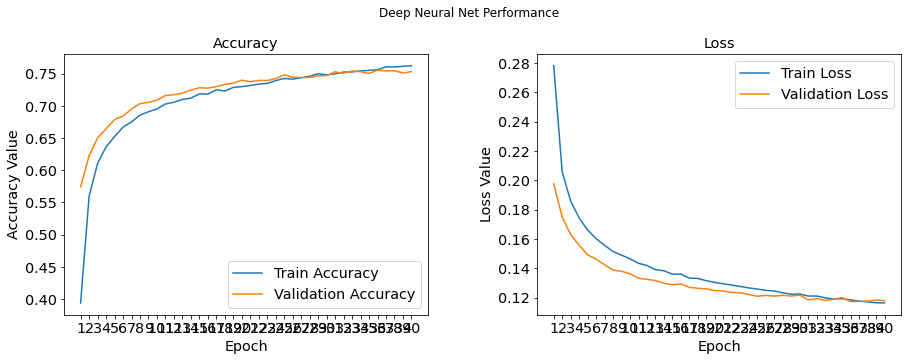

In [18]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
t = f.suptitle('Deep Neural Net Performance', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

epochs = list(range(1,EPOCHS+1))
ax1.plot(epochs, history.history['accuracy'], label='Train Accuracy')
ax1.plot(epochs, history.history['val_accuracy'], label='Validation Accuracy')
ax1.set_xticks(epochs)
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")

ax2.plot(epochs, history.history['loss'], label='Train Loss')
ax2.plot(epochs, history.history['val_loss'], label='Validation Loss')
ax2.set_xticks(epochs)
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")

In [ ]:
model.evaluate(X_test, y_test)